# Introduction

In [1]:
# import libraries
import os
import sys
import math
import numpy as np
import tensorflow as tf
np.set_printoptions(precision=3)

# Input file

In [2]:
data_file = ''

def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

if is_interactive():
    data_file = 'Ant_1.str'
else:
    if ( len(sys.argv) < 2 ):
        print('\nSupply WinProp Raydata file in ASCII format.\n\t\tUsage ', 
              sys.argv[0], ': Raydata_file', '\n')
        exit()
    data_file = str(sys.argv[1])

if ( not os.path.isfile(data_file) ):
    print("\nPlease check the filename", data_file, " and try again.\n")
    exit()

# Parser

This section is a module for parsing incoming ascii file (in str format)

It returns a numerical matrix with 5 columns as shown below:


| Delay(ns)  | Strength(dBuV/m)  |  X-coordinate |  Y-coordinate |  Z-coordinate |
|------------|-------------------|---------------|---------------|---------------|
| 2349.565   |      58.71        |     396.00    |     580.00    |    515.46     |
|  926.787   |      74.92        |     736.00    |     980.00    |    515.06     |
|  ......    |      .....        |     .....     |     ......    |    ......     |
|  ......    |      .....        |     .....     |     ......    |    ......     |
|  808.820   |      76.04        |     756.00    |     980.00    |    517.05     |

In [3]:
# Description:
#   Parse incoming ascii file (in str format)
#
# returns:
#  numpy matrix with 5 columns as follows:
#
#   Delay    FieldStrength   X-coordinate  Y-coordinate  Z-coordinate
#   [ns]       [dBuV/m]       
#   
#
def parse_input(filename):

    point = []
    dataset = []
    with open(filename, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            columns = line.split()

            # Do not look at lines that are empty, 
            # commented or have less than 4 cols.
            if ( len(columns) == 0 or columns[0] == '*' or len(columns) < 4):
                continue ;

            if ( columns[0] == 'PATH' and len(point)==3 ):
                # Parameters: delay (ns) , power (dBuV/m)
                record = [float(num) for num in columns[1:3] + point[:]]
                dataset += record

            if ( columns[0] == 'POINT' ):
                # Co-ordinates x, y, z
                point = columns[1:4]

    return np.asarray(dataset).reshape(-1,5)

# Prepare regression dataset

Read the dat_file and populate dataset matrix.

In [4]:
# Format: Delay Power X Y Z
dataset = parse_input(data_file)

# Data Analysis and Visualization
We'll use different techniques to find feature relationship among data.

## Parallel Plots

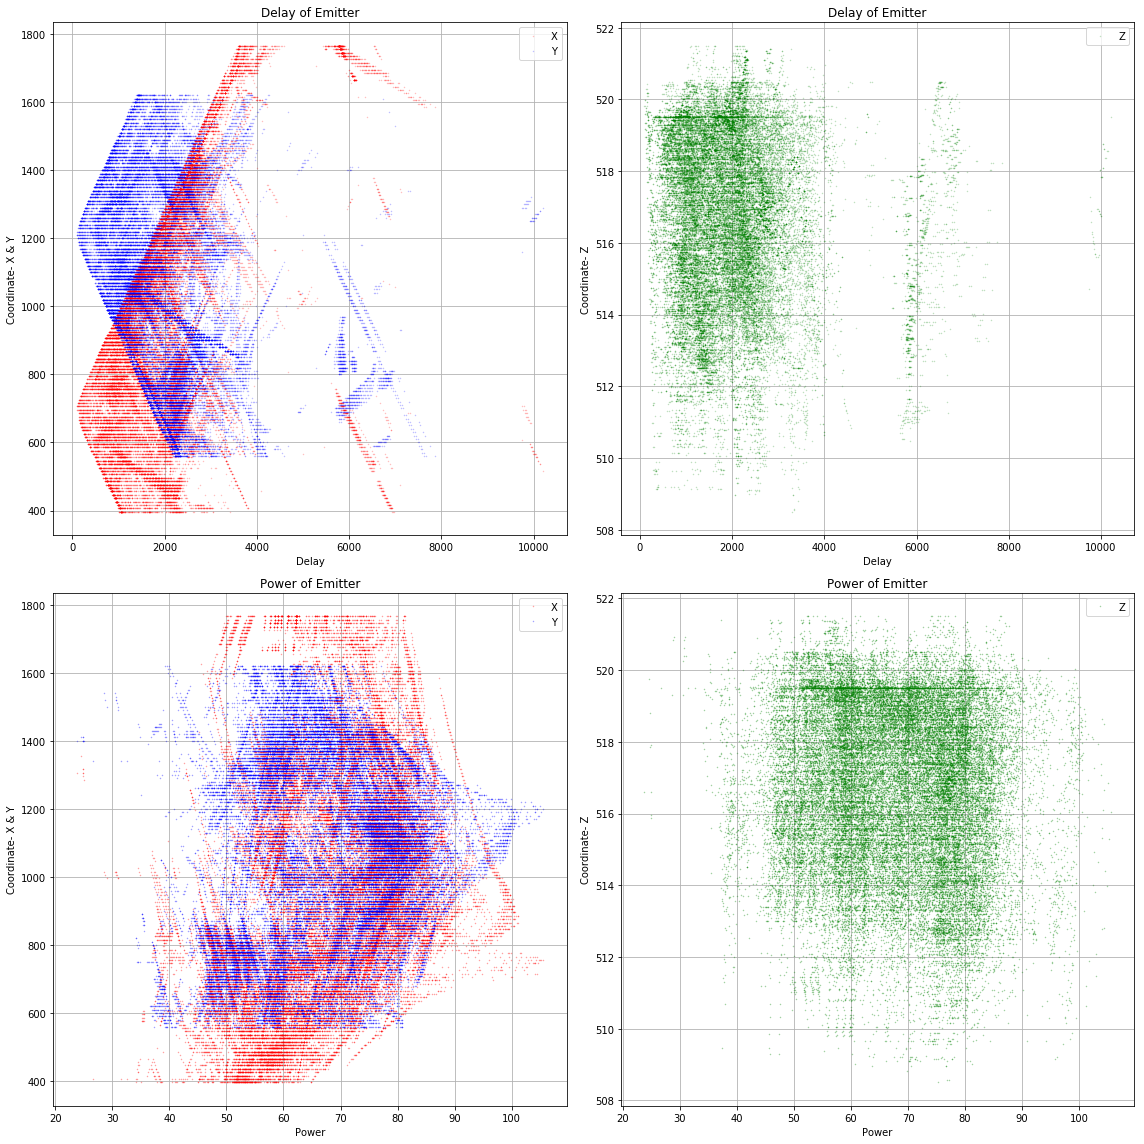

In [5]:
if is_interactive():
    import matplotlib.pyplot as plt

    plt.figure(figsize=(16,16))
    plt.subplot(2, 2, 1)
    plt.title('Delay of Emitter')
    plt.xlabel('Delay')
    plt.ylabel('Coordinate- X & Y')
    plt.grid()
    plt.plot(dataset[:,0], dataset[:,2], 'ro', label='X', marker='*', markersize=1, alpha=0.2)
    plt.plot(dataset[:,0], dataset[:,3], 'bo', label='Y', marker='*', markersize=1, alpha=0.2)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title('Delay of Emitter')
    plt.xlabel('Delay')
    plt.ylabel('Coordinate- Z')
    plt.grid()
    plt.plot(dataset[:,0], dataset[:,4], 'go', label='Z', marker='*', markersize=1, alpha=0.2)
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.title('Power of Emitter')
    plt.xlabel('Power')
    plt.ylabel('Coordinate- X & Y')
    plt.grid()
    plt.plot(dataset[:,1], dataset[:,2], 'ro', label='X', marker='*', markersize=1, alpha=0.3)
    plt.plot(dataset[:,1], dataset[:,3], 'bo', label='Y', marker='*', markersize=1, alpha=0.3)
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.title('Power of Emitter')
    plt.xlabel('Power')
    plt.ylabel('Coordinate- Z')
    plt.grid()
    plt.plot(dataset[:,1], dataset[:,4], 'go', label='Z', marker='*', markersize=1, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

## 3D Scatter Plots

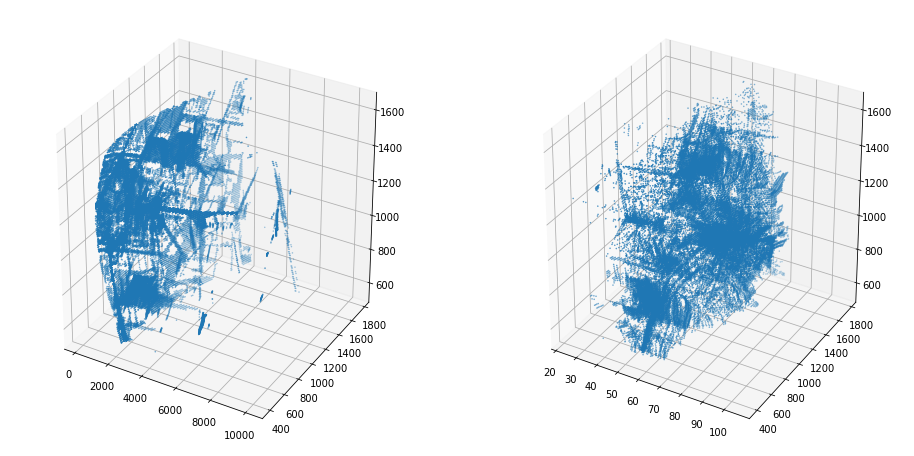

In [6]:
if is_interactive():
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(16,8))

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax = fig.gca(projection='3d')
    ax.scatter(dataset[:,0], dataset[:,2], dataset[:,3], marker='.', s=1)

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax = fig.gca(projection='3d')
    ax.scatter(dataset[:,1], dataset[:,2], dataset[:,3], marker='.', s=1)

    plt.show()

## Euclidean Distance Plot

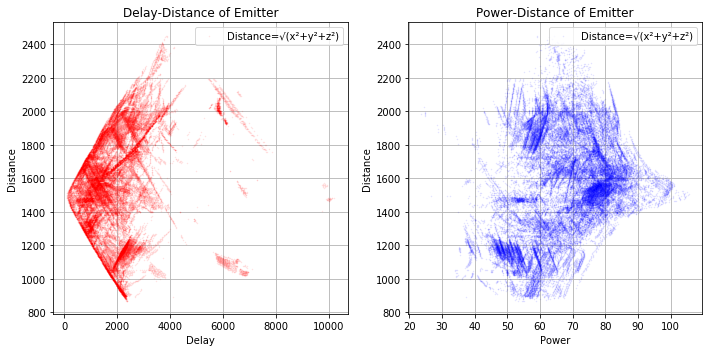

In [7]:
if is_interactive():
    plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    plt.title('Delay-Distance of Emitter')
    plt.xlabel('Delay')
    plt.ylabel('Distance')
    plt.grid()
    plt.plot(dataset[:,0], 
             np.sqrt(dataset[:,2]*dataset[:,2]+dataset[:,3]*dataset[:,3]+dataset[:,4]*dataset[:,4]), 
             'ro', label='Distance=√(x²+y²+z²)', marker='.', markersize=1, alpha=0.1)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Power-Distance of Emitter')
    plt.xlabel('Power')
    plt.ylabel('Distance')
    plt.grid()
    plt.plot(dataset[:,1], 
             np.sqrt(dataset[:,2]*dataset[:,2]+dataset[:,3]*dataset[:,3]+dataset[:,4]*dataset[:,4]), 
             'bo', label='Distance=√(x²+y²+z²)', marker='.', markersize=1, alpha=0.1)
    plt.legend()

    plt.tight_layout()
    plt.show()

## Power Delay Profile

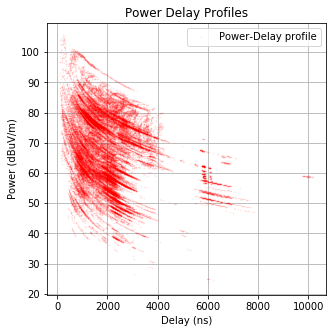

In [8]:
if is_interactive():
    plt.figure(figsize=(5,5))
    plt.title('Power Delay Profiles')
    plt.xlabel('Delay (ns)')
    plt.ylabel('Power (dBuV/m)')
    plt.grid()
    plt.plot(dataset[:,0], dataset[:,1], 'ro', label='Power-Delay profile', marker='.', markersize=1, alpha=0.1)

    plt.legend()
    plt.show()


# Normalize Dataset

In [9]:
# normalize the dataset
data_mean = np.min(dataset, axis=0)*0.99
data_std  = (np.max(dataset, axis=0)-np.min(dataset, axis=0));

def normalize(d, mean, std):
    return (d - mean) / std

def denormalize(d, mean, std):
    return (d * std) + mean

dataset = normalize(dataset, data_mean, data_std)

for i in range(dataset.shape[1]):
    print('Min=', np.min(dataset[:,i]),  'Max=',np.max(dataset[:,i]), 
          'Mean=',np.mean(dataset[:,i]), 'sigma=', np.std(dataset[:,i]))
print('Dataset size', dataset.shape)

Min= 9.67797344297e-05 Max= 1.00009677973 Mean= 0.185761421955 sigma= 0.111279072513
Min= 0.00290535583272 Max= 1.00290535583 Mean= 0.538774195008 sigma= 0.144676403079
Min= 0.00289051094891 Max= 1.00289051095 Mean= 0.40914726192 sigma= 0.244345989001
Min= 0.00528301886792 Max= 1.00528301887 Mean= 0.499474515836 sigma= 0.253718911403
Min= 0.391153846154 Max= 1.39115384615 Mean= 1.01887830531 sigma= 0.178626027054
Dataset size (46391, 5)


# Randomize Dataset

In [10]:
np.random.shuffle(dataset)

# Divide Dataset

In [11]:
# training dataset percentage is 80%
def divide_dataset(dataset):
    train_pct = 0.8; 
    # divide dataset into training and validation set
    train_index = int(dataset.shape[0]*train_pct)
    t_datain  = dataset[:train_index,0:2]
    t_dataout = dataset[:train_index,2:]
    v_datain  = dataset[train_index:,0:2]
    v_dataout = dataset[train_index:,2:]
    
    return t_datain, t_dataout, v_datain, v_dataout

trainIn, trainOut, validIn, validOut = divide_dataset(dataset)

# Machine Learning

##  Hyper Parameters

In [12]:
# Hyper parameters
learning_rate = 1e-1
training_epochs = 1000
display_step = 100

## Graph Nodes
declare plave holders and variables for compute graph

In [13]:
# tf Graph Input
delay = tf.placeholder("float")
power = tf.placeholder("float")
X     = tf.placeholder("float")
Y     = tf.placeholder("float")
Z     = tf.placeholder("float")

dwx = tf.Variable(0.4, name="delay_wx")
dwy = tf.Variable(0.5, name="delay_wy")
dwz = tf.Variable(1.0, name="delay_wz")
pwx = tf.Variable(0.4, name="power_wx")
pwy = tf.Variable(0.5, name="power_wy")
pwz = tf.Variable(1.0, name="power_wz")
bx  = tf.Variable(0.5, name="bias_x")
by  = tf.Variable(0.5, name="bias_y")
bz  = tf.Variable(0.5, name="bias_z")

## Machine Learning Regression Model
Construct a multivariate polynomial model

In [14]:
Xpred = tf.sqrt(dwx*delay*delay + pwx*(power*power-power) + bx)
Ypred = tf.sqrt(dwy*delay*delay + pwy*(power*power-power) + by)
Zpred = tf.sqrt(dwz*delay*delay + pwz*(power*power-power) + bz)

## Cost function

In [15]:
# Mean squared error
cost = tf.reduce_mean((X-Xpred)*(X-Xpred) + (Y-Ypred)*(Y-Ypred) + (Z-Zpred)*(Z-Zpred))

# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

## Training

In [16]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
sess = tf.Session() 
sess.run(init)

for epoch in range(training_epochs):
    _, xp, yp, zp = sess.run([optimizer,Xpred,Ypred,Zpred],
                             feed_dict={delay:trainIn[:,0], power:trainIn[:,1],
                                        X:trainOut[:,0], Y:trainOut[:,1], Z:trainOut[:,2]})
    #print('Location:', xp, yp, zp)

    #Display logs per epoch step
    if (epoch+1) % display_step == 0:
        c = sess.run(cost, feed_dict={delay:trainIn[:,0], power:trainIn[:,1], 
                                      X:trainOut[:,0], Y:trainOut[:,1], Z:trainOut[:,2]})
        print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))


print( "Optimization Finished!" )

Epoch: 0100 cost= 0.156373262
Epoch: 0200 cost= 0.154528961
Epoch: 0300 cost= 0.152893499
Epoch: 0400 cost= 0.151439443
Epoch: 0500 cost= 0.150149509
Epoch: 0600 cost= 0.149010986
Epoch: 0700 cost= 0.148015454
Epoch: 0800 cost= 0.147160485
Epoch: 0900 cost= 0.146451592
Epoch: 1000 cost= 0.145919785
Optimization Finished!


# Save Model Parameters

In [17]:
# print model
# fetch model variables.
xdw, ydw, zdw, xpw, ypw, zpw, xb, yb, zb = sess.run([dwx, dwy, dwz, pwx, pwy, pwz, bx, by, bz], 
                                                    feed_dict={delay:trainIn[:,0], power:trainIn[:,1], 
                                                               X:trainOut[:,0], Y:trainOut[:,1], 
                                                               Z:trainOut[:,2]})

if not math.isnan(c) and not math.isinf(c):
    with open('model_param.py', 'w') as fp:
        fp.write('data_mean=' + np.array2string(data_mean, precision=2, separator=','
                                                ,suppress_small=True)+'\n')
        
        fp.write('data_std=' + np.array2string(data_std, precision=2, separator=','
                                                ,suppress_small=True)+'\n')
        fp.write('idwx=' + str(xdw) + '\n')
        fp.write('idwy=' + str(ydw) + '\n') 
        fp.write('idwz=' + str(zdw) + '\n') 
        fp.write('ipwx=' + str(xpw) + '\n')
        fp.write('ipwy=' + str(ypw) + '\n')
        fp.write('ipwz=' + str(zpw) + '\n')
        fp.write('ibx='  + str(xb)  + '\n')
        fp.write('iby='  + str(yb)  + '\n')
        fp.write('ibz='  + str(zb)  + '\n')

print(xdw, ydw, zdw, xpw, ypw, zpw, xb, yb, zb)

1.1167 -0.253039 0.789271 0.484096 0.321263 0.788351 0.223167 0.335377 1.1839


# Predict Location

In [18]:
def locationModel(d, p):
    x = np.sqrt(xdw*d*d + xpw*(p*p-p) + xb)
    y = np.sqrt(ydw*d*d + ypw*(p*p-p) + yb)
    z = np.sqrt(zdw*d*d + zpw*(p*p-p) + zb)

    return x, y, z

def predictLocation(delay, power):
    d = normalize(delay, data_mean[0], data_std[0])
    p = normalize(power, data_mean[1], data_std[1])
    
    x,y,z = locationModel(d, p)
    
    x = denormalize(x, data_mean[2], data_std[2])
    y = denormalize(y, data_mean[3], data_std[3])
    z = denormalize(z, data_mean[4], data_std[4])

    return x, y, z

# Predict Location Sample

In [19]:
testset = parse_input(data_file)
for i in np.random.choice(testset.shape[0], 10):
    print("{:.1f}".format(testset[i,0]), "{:.1f}".format(testset[i,1]), 
          ':', testset[i, 2:], ' => ', '{:.3f} {:.3f} {:.3f}'.format(*predictLocation(testset[i, 0], testset[i, 1])) )

472.0 52.2 : [  586.   1250.    516.9]  =>  855.497 1096.820 516.450
1410.0 62.3 : [  606.    1020.     518.41]  =>  869.159 1085.465 516.419
2157.5 52.0 : [ 536.    850.    519.15]  =>  939.578 1086.521 516.659
3219.9 70.9 : [ 1596.     920.     518.31]  =>  1022.368 1066.010 516.844
5812.3 59.1 : [ 1766.    800.    513.3]  =>  1322.131 998.607 517.905
1828.5 48.7 : [ 806.    680.    516.39]  =>  927.365 1094.331 516.666
524.7 72.4 : [  666.    1120.     515.89]  =>  843.801 1092.457 516.387
990.2 63.1 : [ 756.    930.    517.74]  =>  848.426 1087.744 516.370
611.7 95.3 : [  816.    1080.     513.53]  =>  964.033 1135.356 517.060
871.2 49.0 : [  466.   1270.    519.5]  =>  878.332 1100.133 516.542


# Error Distribution

In [20]:
def sampleError(dp, gold):
    loc    = np.transpose(locationModel(dp[:, 0], dp[:, 1]))
    loc_r  = np.sqrt(loc[:,0]*loc[:,0]+loc[:,1]*loc[:,1]+loc[:,2]*loc[:,2])
    gold_r = np.sqrt(gold[:,0]*gold[:,0]+gold[:,1]*gold[:,1]+gold[:,2]*gold[:,2])
    error = (gold_r-loc_r)/gold_r
    return 100*error

training_Error   = sampleError(trainIn, trainOut)
validation_Error = sampleError(validIn, validOut)

print('Training   error mean=', np.mean(training_Error),   '%')
print('Validation error mean=', np.mean(validation_Error), '%')

Training   error mean= 1.31062993912 %
Validation error mean= 1.36647986996 %


# Error Distriution Plot

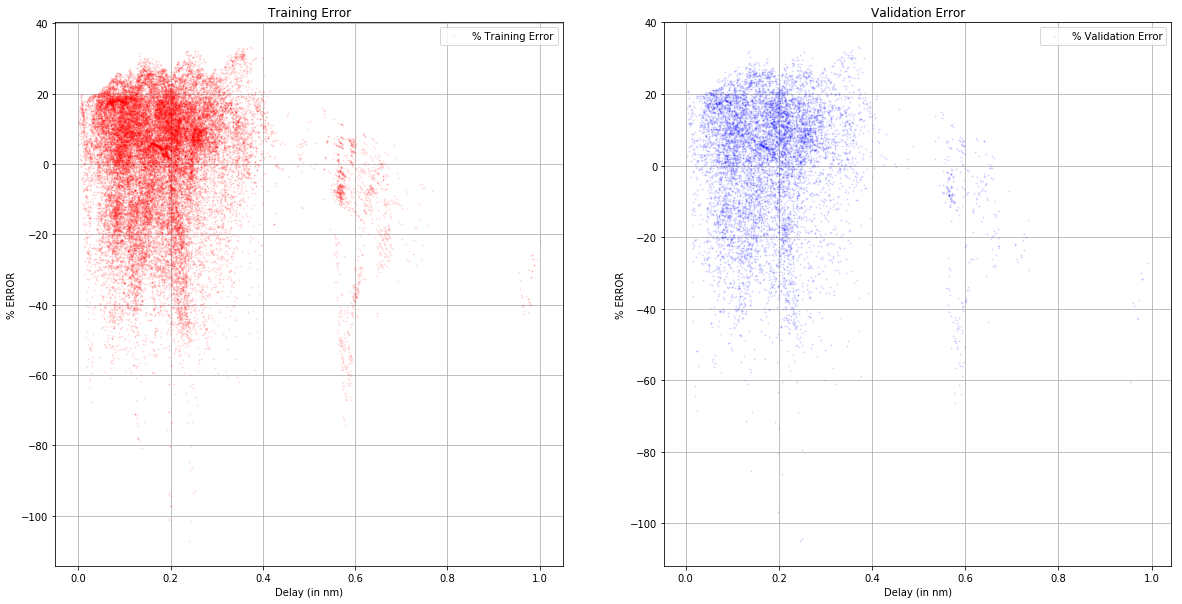

In [21]:
if is_interactive():
    fig = plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.grid()
    plt.plot(trainIn[:,0], training_Error, 'ro', label='% Training Error', marker='o', markersize=1, alpha=0.1)
    plt.title('Training Error')
    plt.xlabel('Delay (in nm)')
    plt.ylabel('% ERROR')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.grid()
    plt.plot(validIn[:,0], validation_Error, 'bo', label='% Validation Error', marker='D', markersize=1, alpha=0.1)
    plt.title('Validation Error')
    plt.xlabel('Delay (in nm)')
    plt.ylabel('% ERROR')
    plt.legend()

    plt.show()

# Correlation

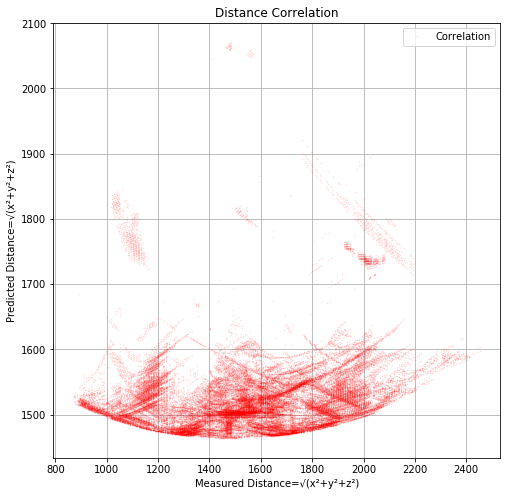

In [22]:
if is_interactive():
    predloc = predictLocation(testset[:, 0], testset[:, 1])

    plt.figure(figsize=(8,8))
    plt.title('Distance Correlation')
    plt.xlabel('Measured Distance=√(x²+y²+z²)')
    plt.ylabel('Predicted Distance=√(x²+y²+z²)')
    plt.grid()
    plt.plot(np.sqrt(testset[:,2]*testset[:,2]+testset[:,3]*testset[:,3]+testset[:,4]*testset[:,4]), 
             np.sqrt(predloc[0]*predloc[0]+predloc[1]*predloc[1]+predloc[2]*predloc[2]), 
             'ro', label='Correlation', marker='*', markersize=1, alpha=0.1)

    plt.legend()
    plt.show()

# Conslusion

We successfully generated model for predicting geolocation of emitters within acceptable accuracy